### Loading Data and Necessary Libraries  

In [25]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [26]:
data= pd.read_csv("sector_51_daily_aqi.csv", index_col=0)
data['Date'] = pd.to_datetime(data['Date'])

## About the Data

This dataset is about Gurugram's daily Air Quality Index. The starting date is March 2020 up to today. The data is updated daily. We have data till *10th November 2024*.

Our data has *1712* rows. Given the worsening quality of air quality in India, this is an important dataset to analyse and make predictions on


In [27]:
data.head()

,Date,AQI
0,2020-03-05,73.0
1,2020-03-06,55.0
2,2020-03-07,78.0
3,2020-03-08,120.0
4,2020-03-09,179.0


In [28]:
data['Date'].max()

Timestamp('2024-11-10 00:00:00')

In [29]:
data['Date'].min()

Timestamp('2020-03-05 00:00:00')

In [30]:
len(data)

1712

In [31]:
data.describe()

,Date,AQI
count,1712,1710.000000
mean,2022-07-08 12:00:00,215.391813
min,2020-03-05 00:00:00,31.000000
25%,2021-05-06 18:00:00,126.000000
50%,2022-07-08 12:00:00,194.000000
75%,2023-09-09 06:00:00,307.000000
max,2024-11-10 00:00:00,937.000000
std,NaN,110.812705


## Cleaning Data

In [32]:
data.isna().sum()

,0
Date,0
AQI,2


In [33]:
data[data["AQI"].isna()]

,Date,AQI
1371,2023-12-06,NaN
1378,2023-12-13,NaN


In [34]:
# Forward Filling the missing values, assuming the next days AQI is almost the same as the current days AQI

data['AQI'] = data['AQI'].fillna(method='ffill')


<ipython-input-34-14521281411d>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['AQI'] = data['AQI'].fillna(method='ffill')


In [35]:
# Checking  if all dates exist between the earliest and latest date

data['Date'] = pd.to_datetime(data['Date'])
full_date_range = pd.date_range(start=data['Date'].min(), end=data['Date'].max(), freq='D')
missing_dates = full_date_range.difference(data['Date'])
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Thus we have all the dates and do not need to worry about missing data here

## Exploratory Data Analysis

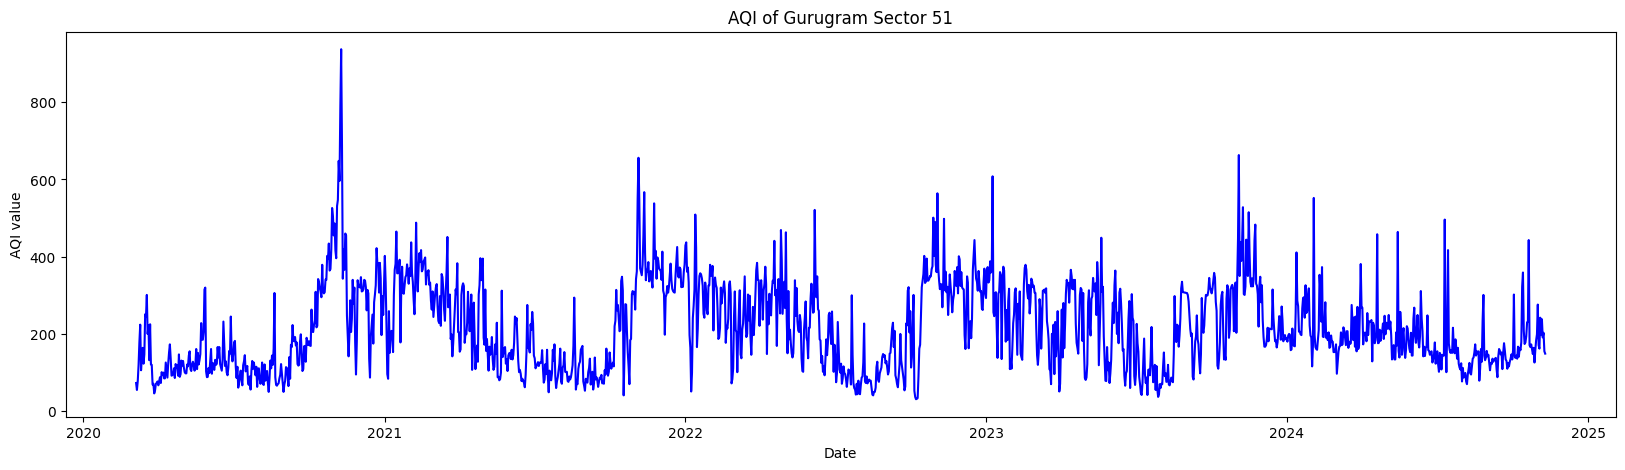

In [36]:
# Plotting Time plot

plt.figure(figsize=(20,5))
plt.plot(data["Date"], data['AQI'], color="blue", label="inflacion")
plt.title('AQI of Gurugram Sector 51')
plt.xlabel('Date')
plt.ylabel('AQI value')
plt.show()

The time series plot of Gurugram AQI shows noticeable fluctuations over time, with certain periods exhibiting high spikes in AQI levels, indicating episodes of severe air pollution.

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1712 entries, 0 to 1711
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1712 non-null   datetime64[ns]
 1   AQI     1712 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 40.1 KB


In [38]:
data1 = data.set_index('Date')
monthly_aqi = data1['AQI'].resample('M').mean()

<ipython-input-38-1d4c7ba337f7>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_aqi = data1['AQI'].resample('M').mean()


In [39]:
def AQ(x):
    if 0 <= x <= 50:
        return 'Good'
    if 50 < x <= 100:
        return 'Satisfactory'
    if 100 < x <= 200:
        return 'Moderate'
    if 200 < x <= 300:
        return 'Poor'
    if 300 < x <= 400:
        return 'Very Poor'
    if x > 400:
        return 'Severe'

In [40]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Air Quality Type'] = data['AQI'].apply(AQ)

<Axes: xlabel='Air Quality Type', ylabel='count'>

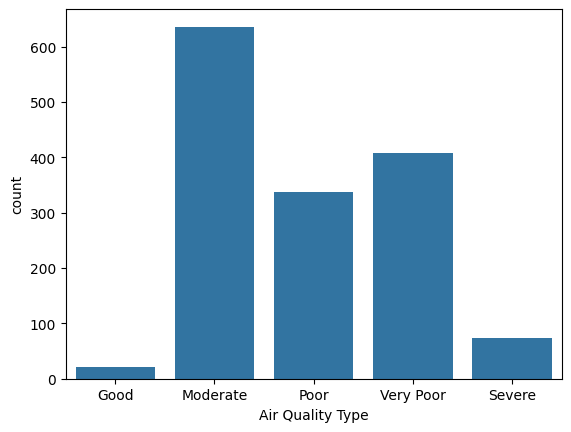

In [41]:
sns.countplot(data=data, x='Air Quality Type', order=['Good','Moderate','Poor','Very Poor','Severe'])

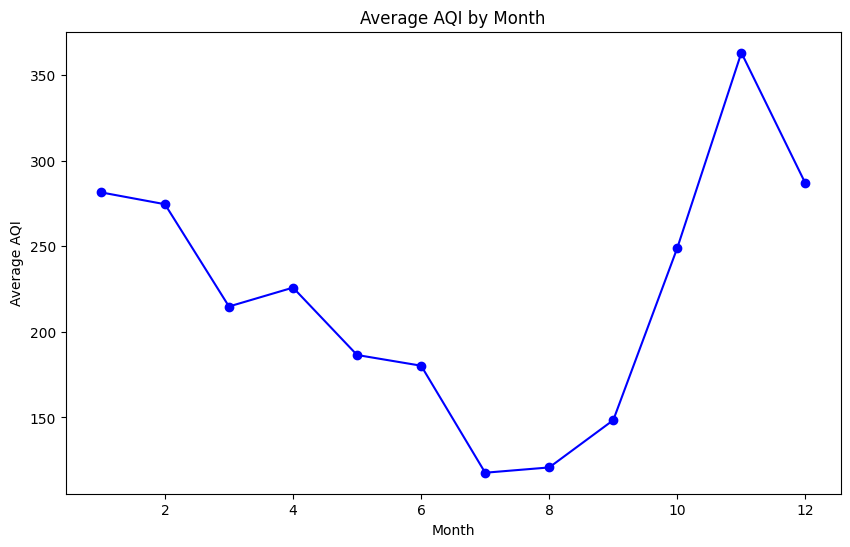

In [42]:
#seasonal Plots
monthly_avg = data.groupby('Month')['AQI'].mean()
plt.figure(figsize=(10, 6))
monthly_avg.plot(kind='line', marker='o', color='b')
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.title('Average AQI by Month')
plt.show()

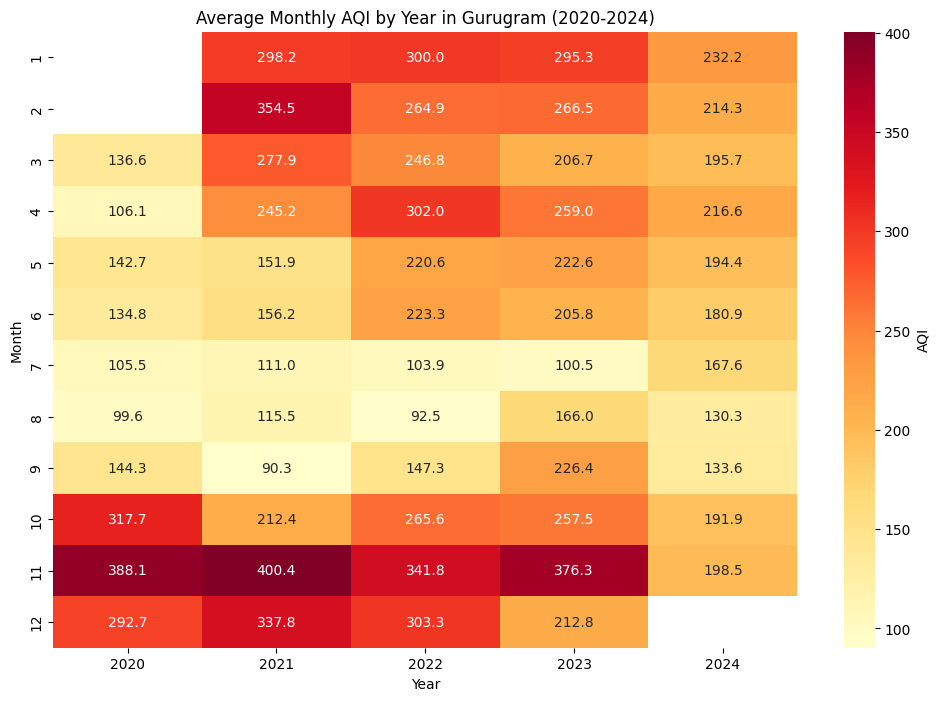

In [43]:
# Grouping by Year and Month to analyze seasonal trends
monthly_avg_aqi = data.groupby(['Year', 'Month'])['AQI'].mean().unstack(level=0)

# Display the data to the user to observe month-wise average AQI for each year
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(monthly_avg_aqi, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'AQI'})
plt.title('Average Monthly AQI by Year in Gurugram (2020-2024)')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


The plot of monthly mean AQI reveals a cyclical pattern, with certain months consistently experiencing higher AQI levels, which may be influenced by seasonal factors like weather, agricultural activities, or traffic patterns.

We know that burning of crops in Punjab during Diwali greatly worsens the Air Quality in Delhi, Delhi NCR and neighbouring areas.

The above plot clearly validates this by showing a spike around the months of October/November

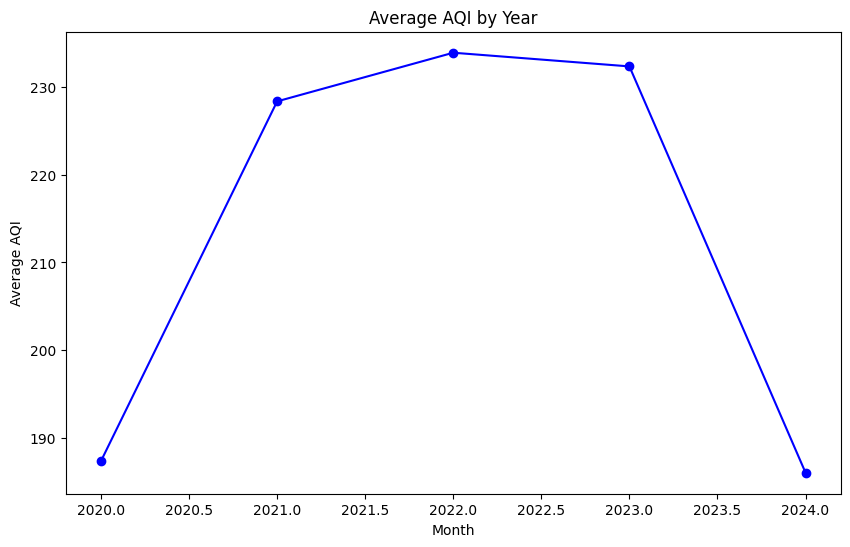

In [44]:

yearly_avg = data.groupby('Year')['AQI'].mean()
plt.figure(figsize=(10, 6))
yearly_avg.plot(kind='line', marker='o', color='b')
plt.xlabel('Month')
plt.ylabel('Average AQI')
plt.title('Average AQI by Year')
plt.show()

## Decomposition

### Daily

In [45]:
!pip install statsmodels

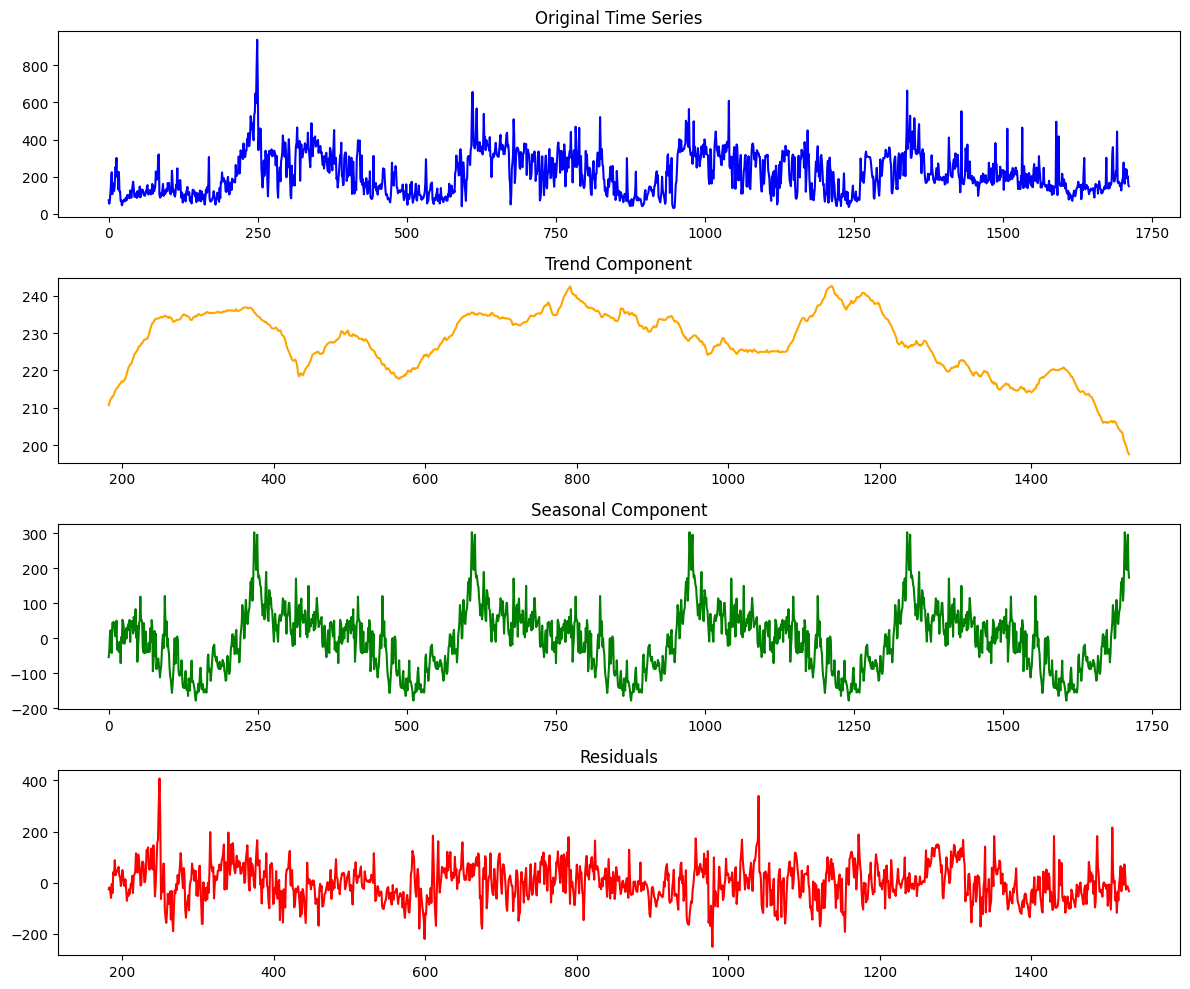

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
decomposition = seasonal_decompose(data['AQI'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(data['AQI'], label='Original', color='blue')
plt.title('Original Time Series')
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Trend Component')
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonal Component')
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title('Residuals')
plt.tight_layout()
plt.show()


### Monthly

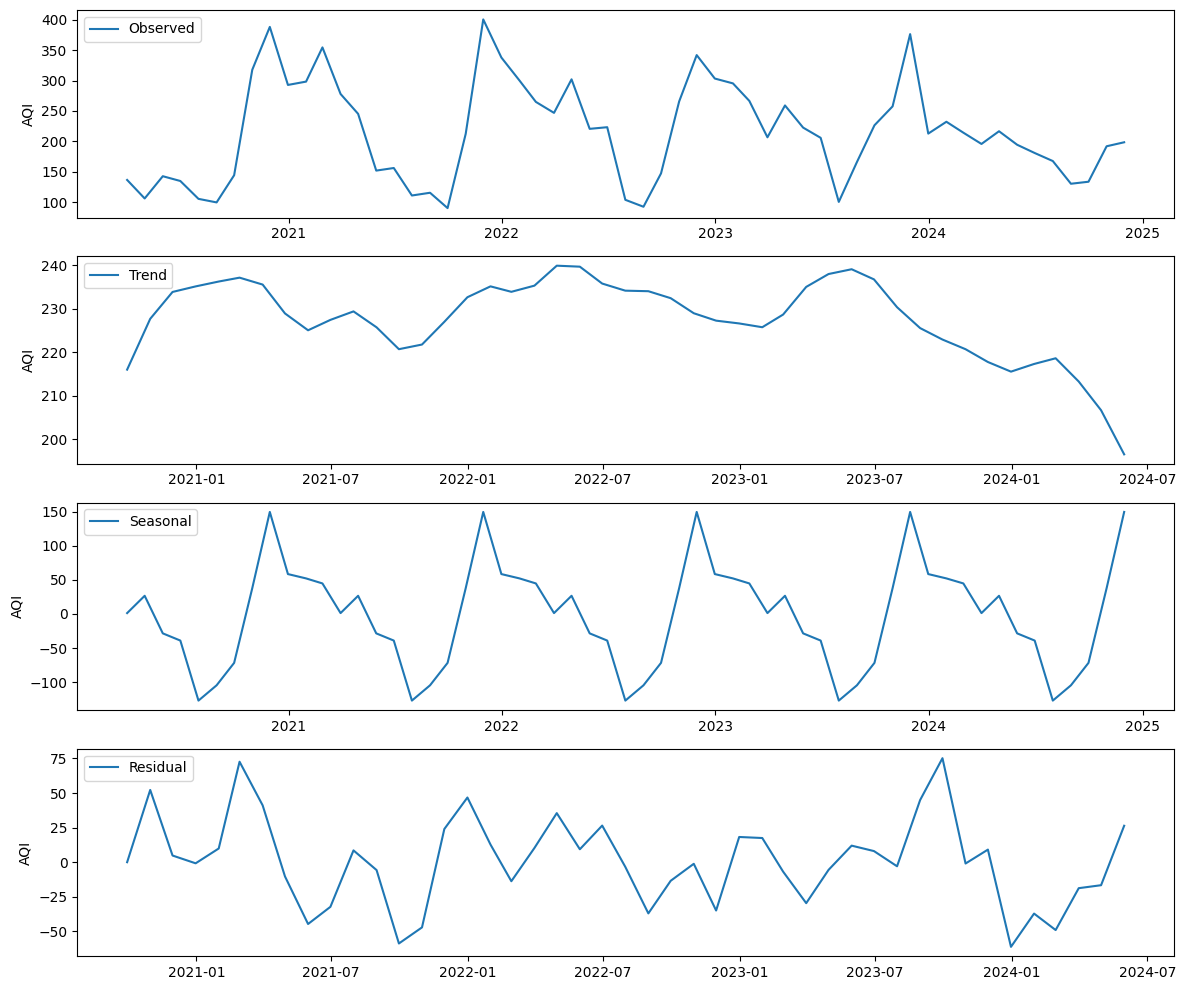

In [47]:
# Plotting the decomposition of the series

from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition of the AQI time series using monthly aggregation
decomposition = seasonal_decompose(monthly_aqi, model='additive')

# Plot the decomposed components
plt.figure(figsize=(12, 10))

# Observed
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.ylabel('AQI')

# Trend
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.ylabel('AQI')

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.ylabel('AQI')

# Residual
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.ylabel('AQI')

plt.tight_layout()
plt.show()


The decomposition plot reveals the following components:

**Observed**: Reflects the original monthly mean AQI series.

**Trend**: Shows an underlying trend in AQI levels over time, indicating potential long-term shifts in air quality.

**Seasonal**: Exhibits a clear seasonal pattern, with recurring peaks and troughs, likely due to seasonal factors impacting AQI.

**Residual**: Captures random fluctuations not explained by the trend or seasonal components.

This decomposition confirms the **presence of seasonal and trend components**, both essential for building an accurate forecasting model.

---



## Trying to find outliers

In [48]:
data.head()

,Date,AQI,Year,Month,Air Quality Type
0,2020-03-05,73.0,2020,3,Satisfactory
1,2020-03-06,55.0,2020,3,Satisfactory
2,2020-03-07,78.0,2020,3,Satisfactory
3,2020-03-08,120.0,2020,3,Moderate
4,2020-03-09,179.0,2020,3,Moderate


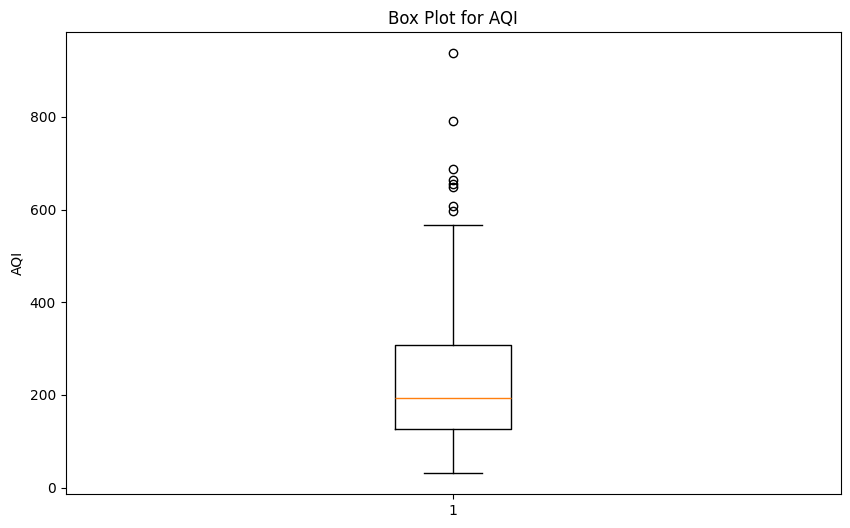

In [49]:
plt.figure(figsize=(10, 6))
plt.boxplot(data['AQI'])  # Drop NaN values if any
plt.title('Box Plot for AQI')
plt.ylabel('AQI')
plt.show()

In [50]:
## Using IQR Method
# Calculate Q1 (25th percentile) and Q3 (85th percentile)
Q1 = data['AQI'].quantile(0.25)
Q3 = data['AQI'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['AQI'] < lower_bound) | (data['AQI'] > upper_bound)]
print("Number of outliers detected:", outliers.shape[0])

Number of outliers detected: 8


In [51]:
outliers

,Date,AQI,Year,Month,Air Quality Type
246,2020-11-06,648.0,2020,11,Severe
247,2020-11-07,596.0,2020,11,Severe
248,2020-11-08,790.0,2020,11,Severe
249,2020-11-09,937.0,2020,11,Severe
250,2020-11-10,688.0,2020,11,Severe
610,2021-11-05,656.0,2021,11,Severe
1040,2023-01-09,608.0,2023,1,Severe
1339,2023-11-04,663.0,2023,11,Severe


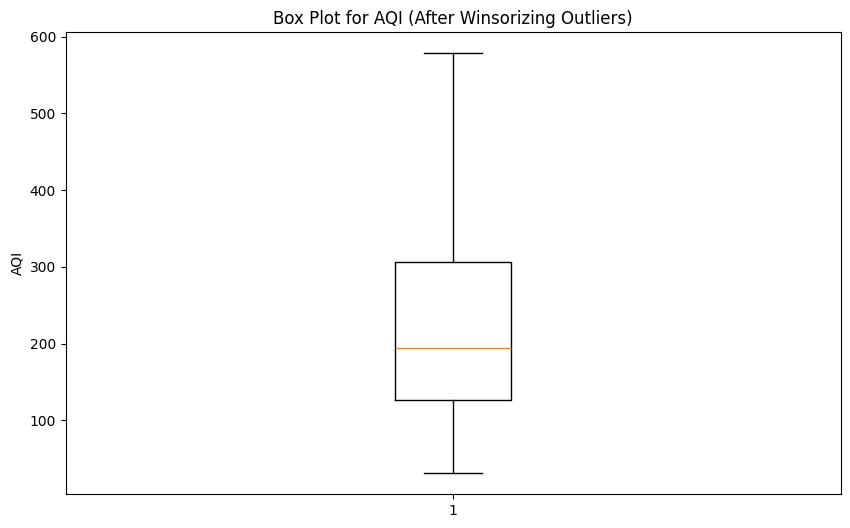

In [52]:
# Winsorizing Outliers - Mapping the outliners to the nearest non-outlier value
data.loc[data['AQI'] > upper_bound, 'AQI'] = upper_bound
plt.figure(figsize=(10, 6))
plt.boxplot(data['AQI'].dropna())
plt.title('Box Plot for AQI (After Winsorizing Outliers)')
plt.ylabel('AQI')
plt.show()

## Stationarity tests

### Monthly Data

In [53]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller (ADF) test on the monthly mean AQI data
adf_test = adfuller(monthly_aqi.dropna())
adf_test_results = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4]
}

pd.DataFrame(adf_test_results)

,ADF Statistic,p-value,Critical Values
1%,0.27655,0.976243,-3.584829
5%,0.27655,0.976243,-2.928299
10%,0.27655,0.976243,-2.602344


The stationarity tests yield the following results:

ADF Test:

Statistic: 0.2765

p-value: 0.9762

The high p-value suggests we cannot reject the null hypothesis of non-stationarity.

In [54]:
monthly_aqi_diff = monthly_aqi.diff().dropna()

# Re-running the ADF on the differenced data
adf_test_diff = adfuller(monthly_aqi_diff)
adf_test_diff_results = {
    "ADF Statistic": adf_test_diff[0],
    "p-value": adf_test_diff[1],
    "Critical Values": adf_test_diff[4]
}

pd.DataFrame(adf_test_diff_results)

,ADF Statistic,p-value,Critical Values
1%,-7.987216,2.530033e-12,-3.584829
5%,-7.987216,2.530033e-12,-2.928299
10%,-7.987216,2.530033e-12,-2.602344


The low p-value suggests we can reject the null hypothesis of non-stationarity.

### Daily

In [55]:
daily_aqi = data[['Date','AQI']]
daily_aqi.set_index('Date', inplace=True)

In [56]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller (ADF) test on the monthly mean AQI data
adf_test = adfuller(monthly_aqi.dropna())
adf_test_results = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4]
}

pd.DataFrame(adf_test_results)

,ADF Statistic,p-value,Critical Values
1%,0.27655,0.976243,-3.584829
5%,0.27655,0.976243,-2.928299
10%,0.27655,0.976243,-2.602344


## ACF and PACF plots

<Figure size 1200x500 with 0 Axes>

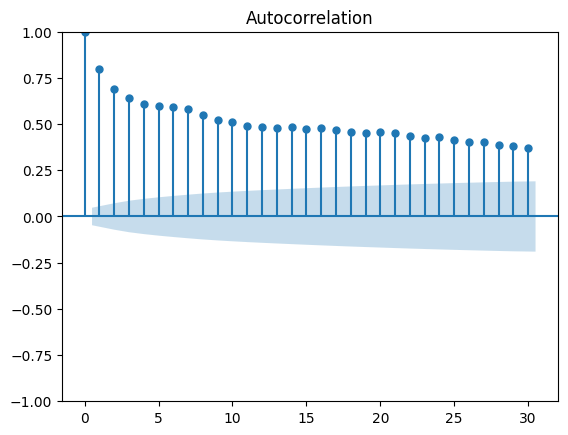

<Figure size 1200x500 with 0 Axes>

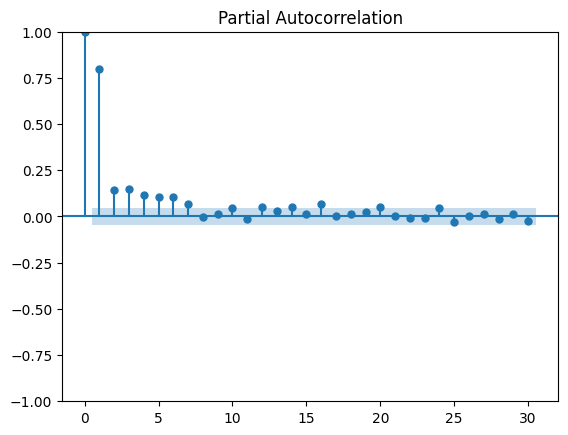

In [57]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 5))
plot_acf(data['AQI'], lags=30)
plt.show()

plt.figure(figsize=(12, 5))
plot_pacf(data['AQI'], lags=30)
plt.show()


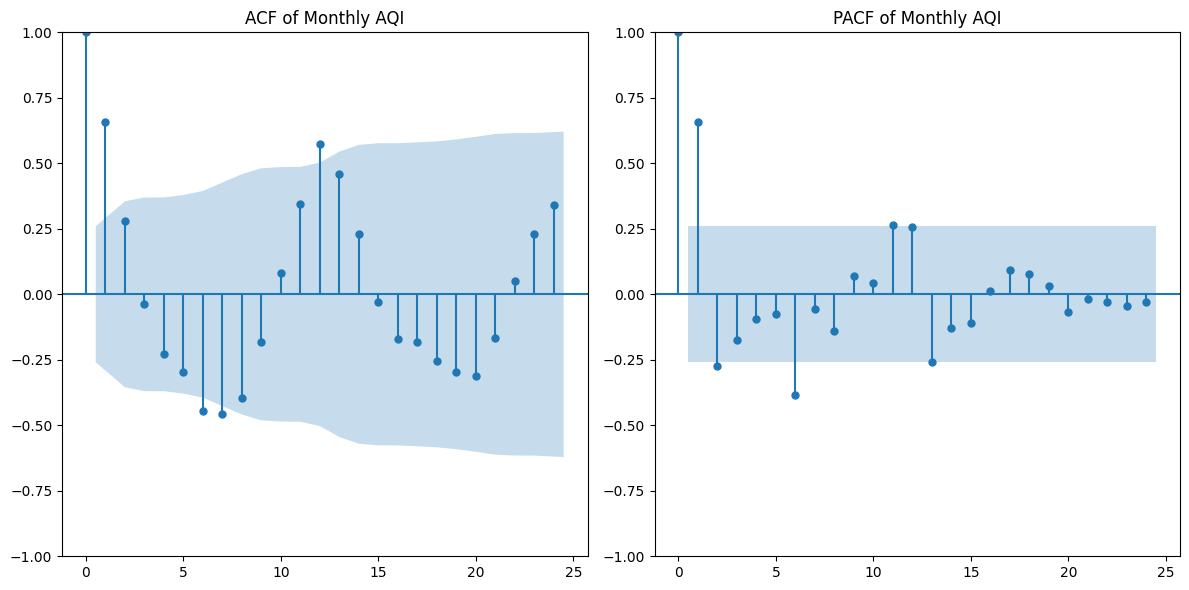

In [58]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting ACF and PACF for the monthly AQI data to help identify AR and MA terms
plt.figure(figsize=(12, 6))

# Autocorrelation function plot
plt.subplot(1, 2, 1)
plot_acf(monthly_aqi, ax=plt.gca(), lags=24)
plt.title('ACF of Monthly AQI')

# Partial Autocorrelation function plot
plt.subplot(1, 2, 2)
plot_pacf(monthly_aqi, ax=plt.gca(), lags=24, method='ywm')
plt.title('PACF of Monthly AQI')

plt.tight_layout()
plt.show()


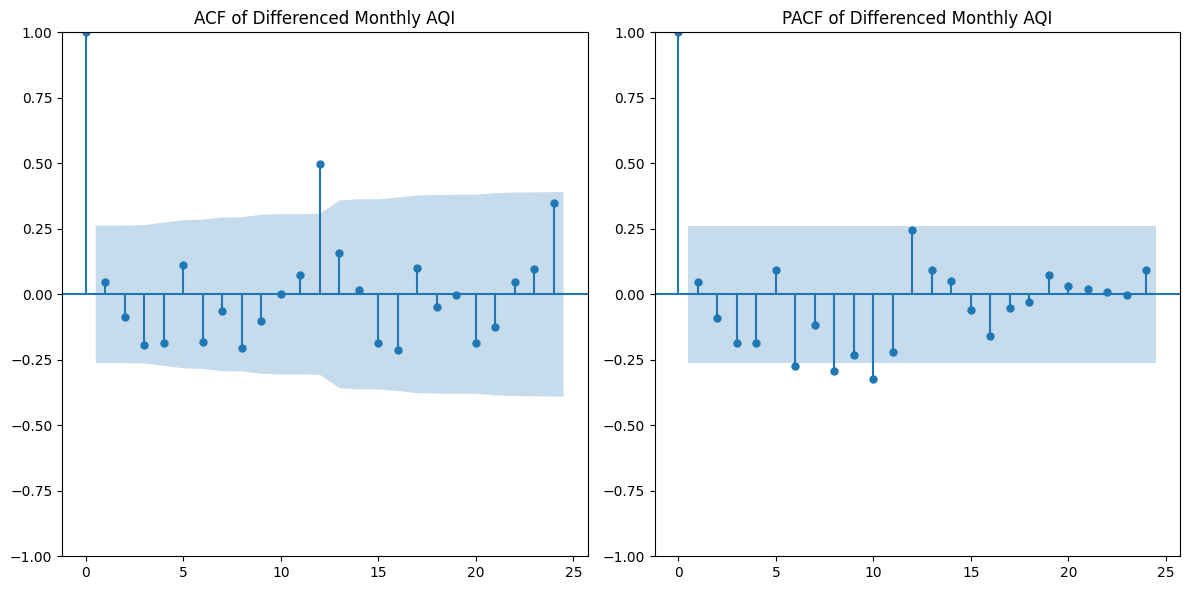

In [59]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting ACF and PACF for the differenced monthly AQI data to help identify AR and MA terms
plt.figure(figsize=(12, 6))

# Autocorrelation function plot
plt.subplot(1, 2, 1)
plot_acf(monthly_aqi_diff, ax=plt.gca(), lags=24)
plt.title('ACF of Differenced Monthly AQI')

# Partial Autocorrelation function plot
plt.subplot(1, 2, 2)
plot_pacf(monthly_aqi_diff, ax=plt.gca(), lags=24, method='ywm')
plt.title('PACF of Differenced Monthly AQI')

plt.tight_layout()
plt.show()


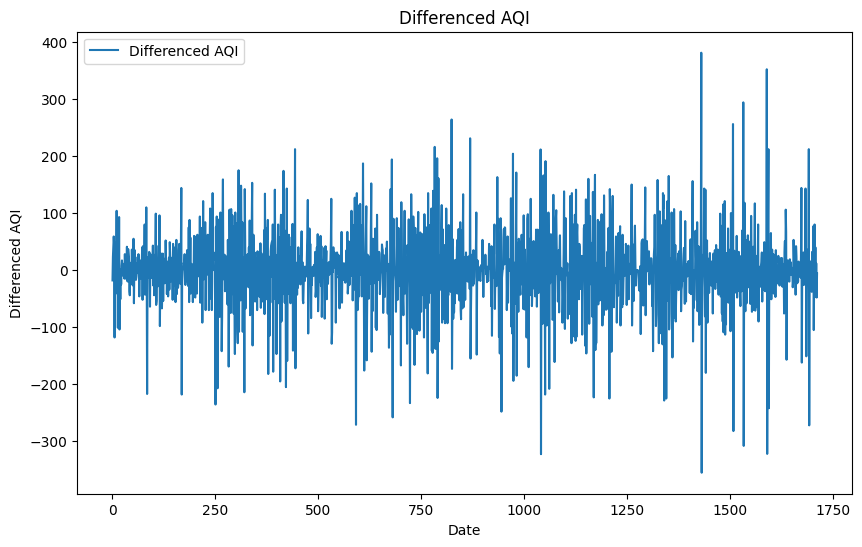

In [60]:
# First-order differencing
data['AQI_diff'] = data['AQI'].diff()
plt.figure(figsize=(10, 6))
plt.plot(data['AQI_diff'], label='Differenced AQI')
plt.title('Differenced AQI')
plt.xlabel('Date')
plt.ylabel('Differenced AQI')
plt.legend()
plt.show()


The differencced data seems to be stationary

## Exponential Smoothing

### Daily Data

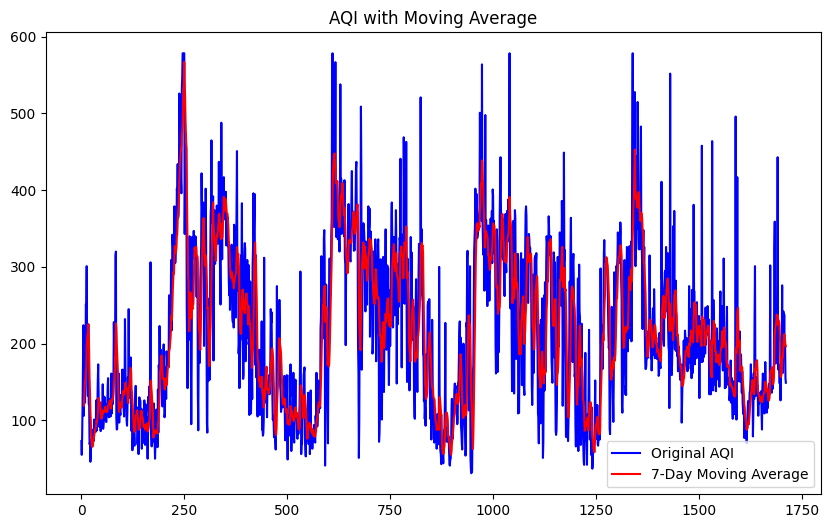

In [61]:
# 7-day moving average
data['AQI_MA'] = data['AQI'].rolling(window=7).mean()
from statsmodels.tsa.holtwinters import ExponentialSmoothing
plt.figure(figsize=(10, 6))
plt.plot(data['AQI'], label='Original AQI', color='blue')
plt.plot(data['AQI_MA'], label='7-Day Moving Average', color='red')
plt.title('AQI with Moving Average')
plt.legend()
plt.show()

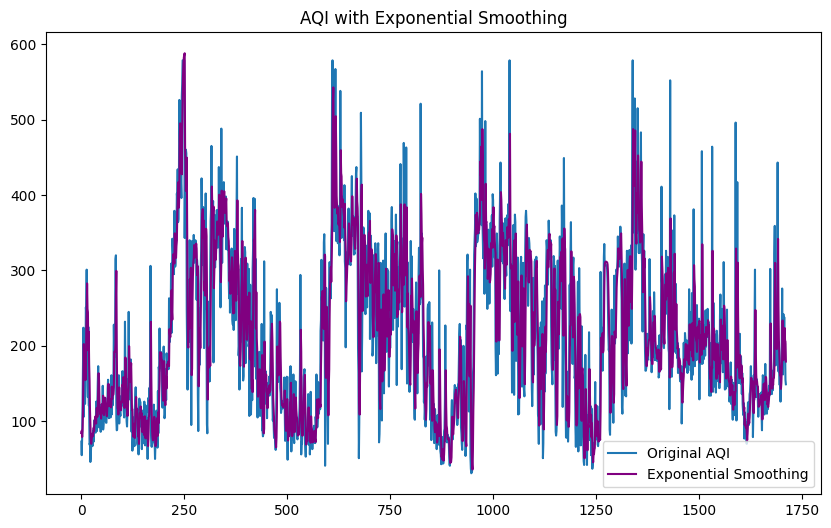

In [62]:
# Fit an exponential smoothing model
exp_smooth = ExponentialSmoothing(data['AQI'], trend='add', seasonal=None, seasonal_periods=365).fit()
data['AQI_ES'] = exp_smooth.fittedvalues
# Plot original and smoothed data
plt.figure(figsize=(10, 6))
plt.plot(data['AQI'], label='Original AQI')
plt.plot(data['AQI_ES'], label='Exponential Smoothing', color='purple')
plt.title('AQI with Exponential Smoothing')
plt.legend()
plt.show()

### Monthly Data

In [63]:
monthly = monthly_aqi.reset_index()

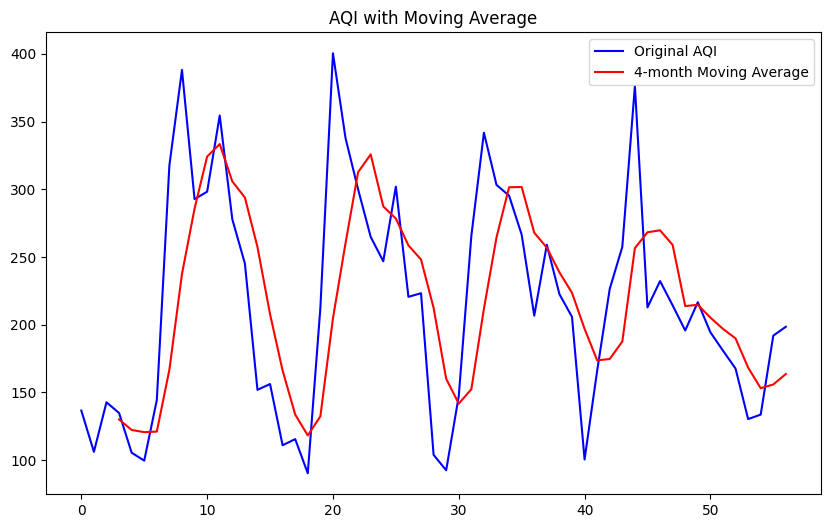

In [64]:
# 2 month moving average
monthly['AQI_MA'] = monthly['AQI'].rolling(window=4).mean()
from statsmodels.tsa.holtwinters import ExponentialSmoothing
plt.figure(figsize=(10, 6))
plt.plot(monthly['AQI'], label='Original AQI', color='blue')
plt.plot(monthly['AQI_MA'], label='4-month Moving Average', color='red')
plt.title('AQI with Moving Average')
plt.legend()
plt.show()

## Models

In [65]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 77.3 MB/s eta 0:00:00


### Daily

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=15207.611, Time=0.78 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=16894.618, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=15298.570, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=16024.593, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19004.128, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=15226.533, Time=0.46 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=15207.097, Time=0.61 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=15273.298, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=15282.561, Time=0.14 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=15208.532, Time=0.75 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=15262.122, Time=0.12 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.47 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0] intercept
Total fit time: 4.814 seconds


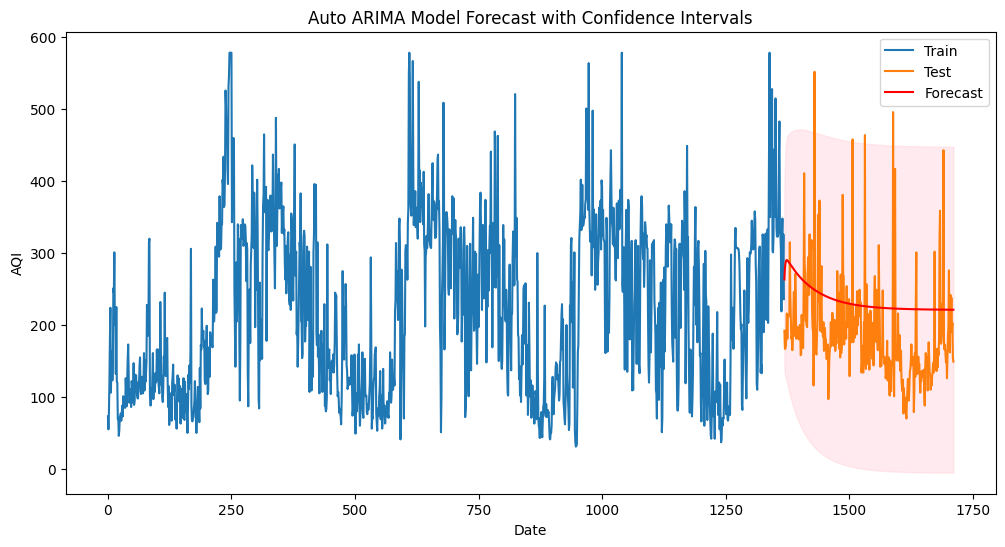

Optimal ARIMA parameters: (2, 0, 1)
Root Mean Squared Error: 78.82475072555772
Mean Absolute Error: 67.04822229084277


In [82]:
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Split the data into 80% train and 20% test
train_size = int(len(data) * 0.8)
train, test = data['AQI'][:train_size], data['AQI'][train_size:]

# Fit Auto ARIMA to find the best parameters
auto_arima_model = pm.auto_arima(train, seasonal=True, d = 0, stepwise=True, trace=True)

# Forecast for the test period with confidence intervals
forecast, conf_int = auto_arima_model.predict(n_periods=len(test), return_conf_int=True)

# Create a DataFrame for the test set and include the forecast and confidence intervals
# Use the original index from the 'test' Series
test_df = pd.DataFrame({'AQI': test, 'Forecast': forecast,
                        'Lower Bound': conf_int[:, 0], 'Upper Bound': conf_int[:, 1]},
                       index=test.index)

# Plot the forecasted values with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test_df['AQI'], label='Test')  # Access 'AQI' from test_df
plt.plot(test_df['Forecast'], label='Forecast', color='red')  # Access 'Forecast' from test_df
plt.fill_between(test_df.index, test_df['Lower Bound'], test_df['Upper Bound'], color='pink', alpha=0.3)  # Access bounds from test_df
plt.title('Auto ARIMA Model Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_df['AQI'], test_df['Forecast'])  # Access values from test_df
mae = mean_absolute_error(test_df['AQI'], test_df['Forecast'])  # Access values from test_df
print(f'Optimal ARIMA parameters: {auto_arima_model.order}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')
print(f'Mean Absolute Error: {mae}')

### Monthly

In [85]:
monthly_aqi = monthly_aqi.reset_index()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=352.540, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=352.699, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=351.439, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=353.655, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=353.359, Time=0.22 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=351.986, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=355.360, Time=0.27 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=350.894, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=352.777, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=352.778, Time=0.13 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=350.803, Time=0.05 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=352.777, Time=0.10 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AI

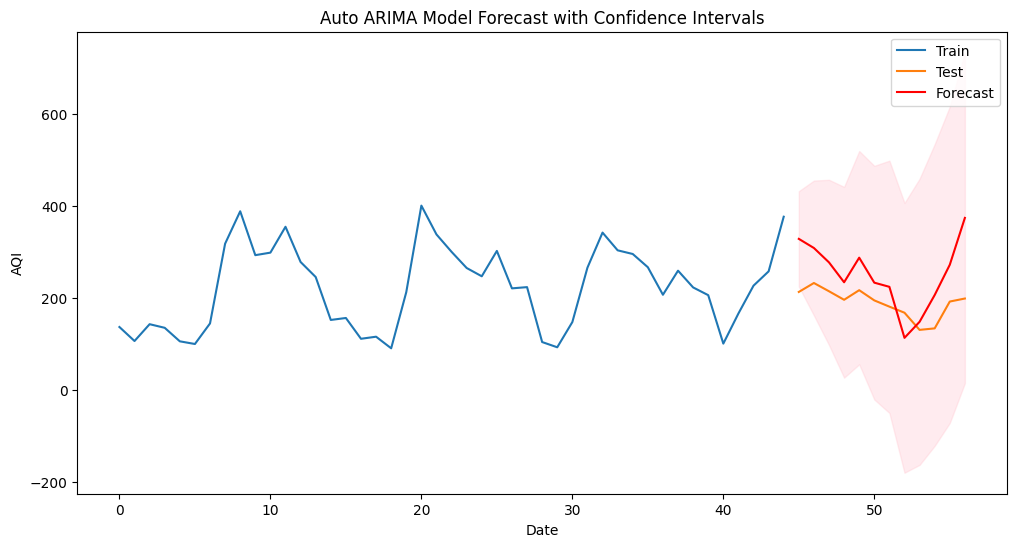

Optimal ARIMA parameters: (0, 1, 0)
Root Mean Squared Error: 80.86797196196953
Mean Absolute Error: 70.37300862010564


In [ ]:
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

monthly_aqi = monthly_aqi.reset_index()
# Split the data into 80% train and 20% test
train_size = int(len(monthly_aqi) * 0.8)
train, test = monthly_aqi['AQI'][:train_size], monthly_aqi['AQI'][train_size:]

# Fit Auto ARIMA to find the best parameters
auto_arima_model = pm.auto_arima(train,
                                 start_p=1, start_q=1,       # Starting values for p and q
                                 max_p=5, max_q=5,           # Wider range for p and q
                                 d=1,                     # Allow auto_arima to determine optimal d
                                 start_P=0, start_Q=0,       # Starting values for seasonal p and q
                                 max_P=3, max_Q=3,           # Wider range for seasonal p and q
                                 D=1,                        # Seasonal differencing (assuming seasonality)
                                 m=12,                       # Monthly seasonality
                                 seasonal=True,
                                 stepwise=True,
                                 trace=True,
                                 error_action='ignore',
                                 suppress_warnings=True)

# Forecast for the test period with confidence intervals
forecast, conf_int = auto_arima_model.predict(n_periods=len(test), return_conf_int=True)

# Create a DataFrame for the test set and include the forecast and confidence intervals
# Use the original index from the 'test' Series
test_df = pd.DataFrame({'AQI': test, 'Forecast': forecast,
                        'Lower Bound': conf_int[:, 0], 'Upper Bound': conf_int[:, 1]},
                       index=test.index)

# Plot the forecasted values with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test_df['AQI'], label='Test')  # Access 'AQI' from test_df
plt.plot(test_df['Forecast'], label='Forecast', color='red')  # Access 'Forecast' from test_df
plt.fill_between(test_df.index, test_df['Lower Bound'], test_df['Upper Bound'], color='pink', alpha=0.3)  # Access bounds from test_df
plt.title('Auto ARIMA Model Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()

# Calculate evaluation metrics
mse = mean_squared_error(test_df['AQI'], test_df['Forecast'])  # Access values from test_df
mae = mean_absolute_error(test_df['AQI'], test_df['Forecast'])  # Access values from test_df
print(f'Optimal ARIMA parameters: {auto_arima_model.order}')
print(f'Root Mean Squared Error: {math.sqrt(mse)}')
print(f'Mean Absolute Error: {mae}')

## LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['AQI']])

# Define look-back period for sequences (e.g., 30 days)
look_back = 30

# Prepare sequences for LSTM
def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, look_back)

# Reshape data for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [95]:
# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [96]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')


In [97]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
43/43 [==============================] - 5s 40ms/step - loss: 0.0399 - val_loss: 0.0121
Epoch 2/20
43/43 [==============================] - 1s 22ms/step - loss: 0.0209 - val_loss: 0.0121
Epoch 3/20
43/43 [==============================] - 1s 21ms/step - loss: 0.0205 - val_loss: 0.0150
Epoch 4/20
43/43 [==============================] - 1s 21ms/step - loss: 0.0194 - val_loss: 0.0123
Epoch 5/20
43/43 [==============================] - 1s 24ms/step - loss: 0.0182 - val_loss: 0.0127
Epoch 6/20
43/43 [==============================] - 1s 22ms/step - loss: 0.0187 - val_loss: 0.0125
Epoch 7/20
43/43 [==============================] - 1s 22ms/step - loss: 0.0173 - val_loss: 0.0124
Epoch 8/20
43/43 [==============================] - 1s 22ms/step - loss: 0.0164 - val_loss: 0.0132
Epoch 9/20
43/43 [==============================] - 1s 22ms/step - loss: 0.0168 - val_loss: 0.0125
Epoch 10/20
43/43 [==============================] - 1s 25ms/step - loss: 0.0163 - val_loss: 0.0125
Epoch 11/

In [98]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse scale the predictions
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Convert y_train and y_test back to original scale
y_train = y_train_inv[0]
y_test = y_test_inv[0]


11/11 [==============================] - 0s 8ms/step


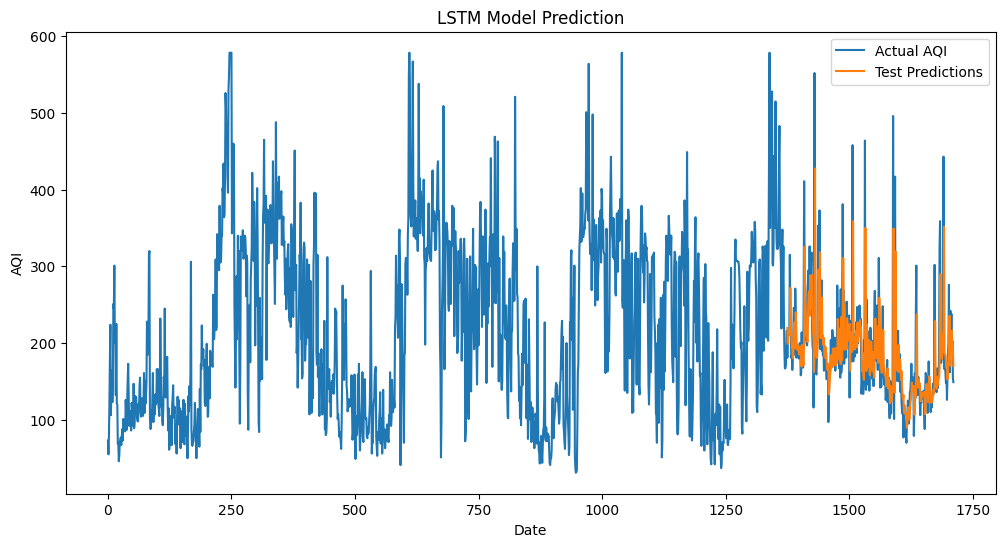

LSTM Model - Root Mean Squared Error: 62.912172103516724
LSTM Model - Mean Absolute Error: 37.768189925468285


In [99]:
# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))

# Prepare the train plot (set values to NaN and place train predictions correctly)
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict) + look_back, :] = train_predict

# Prepare the test plot (set values to NaN and place test predictions correctly)
test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan

# Calculate the correct starting index for test predictions
start_index_test = len(scaled_data) - len(test_predict)

# Assign the test predictions to the correct slice of test_plot
test_plot[start_index_test : , :] = test_predict
#test_plot[len(train_predict) + look_back*2:len(train_predict) + look_back*2 + len(test_predict), :] = test_predict #Original line

# Plot the actual AQI and predictions
plt.plot(scaler.inverse_transform(scaled_data), label='Actual AQI')
plt.plot(test_plot, label='Test Predictions')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('LSTM Model Prediction')
plt.legend()
plt.show()

# Calculate error metrics
mse = mean_squared_error(y_test, test_predict)
mae = mean_absolute_error(y_test, test_predict)

# Output the error metrics
print(f'LSTM Model - Root Mean Squared Error: {math.sqrt(mse)}')
print(f'LSTM Model - Mean Absolute Error: {mae}')

Holt-Winters Model:

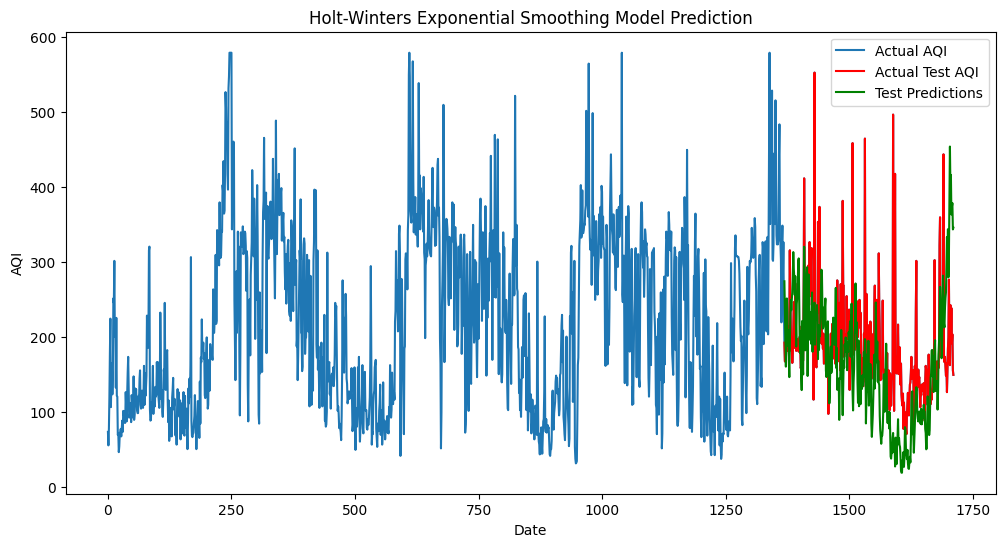

Holt-Winters Model - Root Mean Squared Error: 88.57411577491948
Holt-Winters Model - Mean Absolute Error: 66.0385231084685


In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming 'data' is your time series (AQI data) that is already scaled and prepared.

# Step 1: Train-Test Split
train_size = int(len(scaled_data) * 0.8)  # 80% train, 20% test
train, test = scaled_data[:train_size], scaled_data[train_size:]

# Step 2: Fit the Holt-Winters Exponential Smoothing model
holt_winters_model = ExponentialSmoothing(train, seasonal='add', seasonal_periods=365)  # Adjust seasonal_periods as needed
holt_winters_model_fitted = holt_winters_model.fit()

# Step 3: Make Predictions on the Test Data
test_predictions = holt_winters_model_fitted.forecast(len(test))

# Step 4: Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual AQI')
plt.plot(np.arange(len(train), len(train) + len(test)), scaler.inverse_transform(test), label='Actual Test AQI', color='red')
plt.plot(np.arange(len(train), len(train) + len(test)), scaler.inverse_transform(test_predictions.reshape(-1, 1)), label='Test Predictions', color='green')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.title('Holt-Winters Exponential Smoothing Model Prediction')
plt.legend()
plt.show()

# Step 5: Calculate error metrics
mse = mean_squared_error(scaler.inverse_transform(test), scaler.inverse_transform(test_predictions.reshape(-1, 1)))
mae = mean_absolute_error(scaler.inverse_transform(test), scaler.inverse_transform(test_predictions.reshape(-1, 1)))
print(f'Holt-Winters Model - Root Mean Squared Error: {math.sqrt(mse)}')
print(f'Holt-Winters Model - Mean Absolute Error: {mae}')


In [101]:
from statsmodels.tsa.stattools import adfuller

# Step 6: Check if the entire data is stationary using the Augmented Dickey-Fuller (ADF) test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("The data is stationary (reject the null hypothesis).")
    else:
        print("The data is non-stationary (fail to reject the null hypothesis).")

# Apply ADF test to the entire dataset (scaled_data)
adf_test(data["AQI"])


ADF Statistic: -4.194594359570278
p-value: 0.0006729212804478976
The data is stationary (reject the null hypothesis).


In [102]:
adfuller(data["AQI"])

(-4.194594359570278,
 0.0006729212804478976,
 15,
 1696,
 {'1%': -3.4342115713566796,
  '5%': -2.863245666499036,
  '10%': -2.567678052034198},
 18738.5647038155)